In [ ]:
# Flisol Live 2021 - https://github.com/alexcamargoweb/flisol-2021
# "Inteligência Artificial aplicada: reconhecendo caracteres escritos à mão".
# Author: Alex Dias Camargo - https://apus.digital
# Adapted from: Adrian Rosebrock - https://pyimagesearch.com
# File: flisol-2021.ipynb

In [ ]:
# load data from google drive
from google.colab import drive, output
drive.mount('/content/drive')
# clear terminal outputs
output.clear()
%cd /content/drive/MyDrive/flisol-2021/

# OCR with Keras, TensorFlow, and Deep Learning (part 1)
### by [PyImageSearch.com](http://www.pyimagesearch.com)

In [ ]:
# tensorFlow framework installation
!pip install tensorflow==2.2.0

In [ ]:
# download the dataset zip file
!wget https://apus.digital/ia/datasets/a_z_handwritten_data.zip
!unzip a_z_handwritten_data.zip
!rm a_z_handwritten_data.zip
%ls

In [16]:
# import the necessary packages
from pyimagesearch.models import ResNet
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
from imutils.contours import sort_contours
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [6]:
# function to display images in Jupyter Notebooks and Google Colab
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [7]:
# our OCR dataset helper functions
def load_az_dataset(datasetPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# loop over the rows of the A-Z handwritten digit dataset
	for row in open(datasetPath):
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")

		# images are represented as single channel (grayscale) images
		# that are 28x28=784 pixels -- we need to take this flattened
		# 784-d list of numbers and repshape them into a 28x28 matrix
		image = image.reshape((28, 28))

		# update the list of data and labels
		data.append(image)
		labels.append(label)

    # convert the data and labels to NumPy arrays
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")

	# return a 2-tuple of the A-Z data and labels
	return (data, labels)

In [8]:
# MNIST dataset download
def load_mnist_dataset():
	# load the MNIST dataset and stack the training data and testing
	# data together (we'll create our own training and testing splits
	# later in the project)
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])

	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

In [9]:
# Training our OCR Model using Keras and TensorFlow

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"az": "a_z_handwritten_data.csv",
    "model": "handwriting.model",
    "plot": "plot.png"
}

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 1
INIT_LR = 1e-1
BS = 128

# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset(args["az"])
(digitsData, digitsLabels) = load_mnist_dataset()

In [11]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [12]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

In [13]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [14]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [15]:
# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] training network...
Epoch 1/5
2765/2765 [==============================] - 181s 66ms/step - loss: 2.6512 - accuracy: 0.8445 - val_loss: 0.5744 - val_accuracy: 0.8880
Epoch 2/5
2765/2765 [==============================] - 184s 66ms/step - loss: 1.3877 - accuracy: 0.9024 - val_loss: 0.5392 - val_accuracy: 0.8950
Epoch 3/5
2765/2765 [==============================] - 183s 66ms/step - loss: 1.2738 - accuracy: 0.9080 - val_loss: 0.5243 - val_accuracy: 0.8997
Epoch 4/5
2765/2765 [==============================] - 183s 66ms/step - loss: 1.2161 - accuracy: 0.9115 - val_loss: 0.5044 - val_accuracy: 0.9080
Epoch 5/5
2765/2765 [==============================] - 183s 66ms/step - loss: 1.1797 - accuracy: 0.9138 - val_loss: 0.5033 - val_accuracy: 0.9078
[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.19      0.78      0.31      1381
           1       0.97      0.97      0.97      1575
           2       0.88      0.93      0.91      13

[INFO] serializing network...


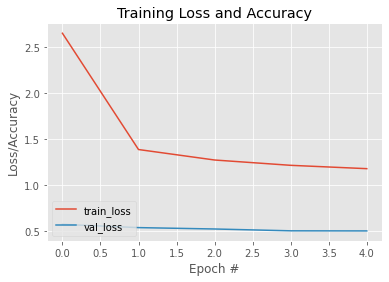

In [17]:
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

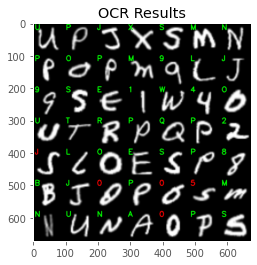

In [18]:
# initialize our list of output test images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)

	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
plt_imshow("OCR Results", montage)

# OCR: Handwriting recognition with OpenCV, Keras, and TensorFlow (part 2)


### by [PyImageSearch.com](http://www.pyimagesearch.com)

In [40]:
# Implementing our handwriting recognition OCR script with OpenCV, Keras, and TensorFlow

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "image": "images/hello_world.png",
  #"image": "images/flisol-2021.jpg",
	"model": "handwriting_full_train.model"
}

[INFO] loading handwriting OCR model...
[INFO] H - 92.48%


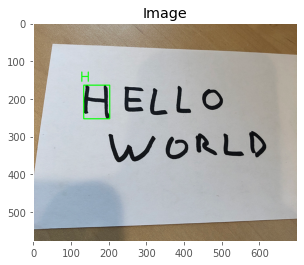

[INFO] W - 54.50%


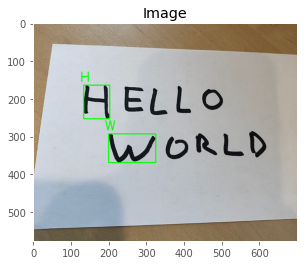

[INFO] E - 94.93%


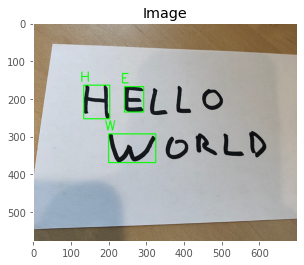

[INFO] L - 97.58%


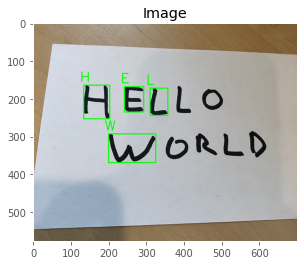

[INFO] 2 - 65.73%


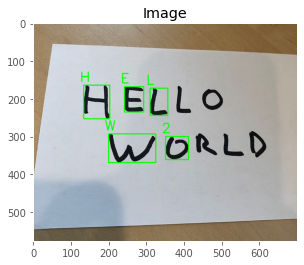

[INFO] L - 96.56%


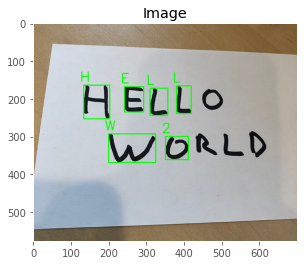

[INFO] R - 97.31%


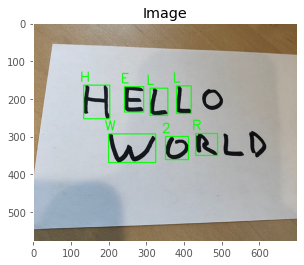

[INFO] 0 - 37.92%


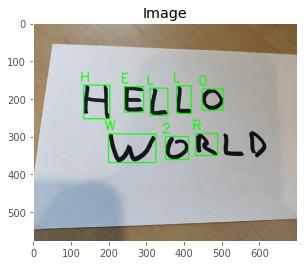

[INFO] L - 97.13%


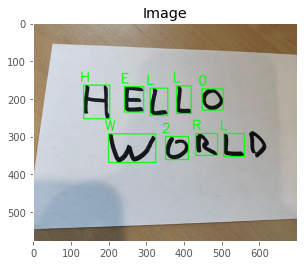

[INFO] D - 97.83%


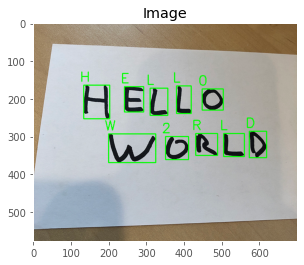

In [41]:
# load the handwriting OCR model
print("[INFO] loading handwriting OCR model...")
model = load_model(args["model"])

# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]

	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

	# show the image
	plt_imshow("Image", image)